# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">3</span>
* 2. Part B: <span style="color:red;">1</span>
* 3. Part C: <span style="color:red;">1</span>
* 4. Tests: <span style="color:red;">2</span>
* 5. Challenge 1: <span style="color:red;">3</span>
* 6. Challenge 2: <span style="color:red;">2</span>
* 7. Write-up: <span style="color:red;">1</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [1]:
import cv2
import matplotlib.pyplot as plt

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

In [2]:
image = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
import numpy as np

def find_border(image):
    image_shape = image.shape
    new_image = np.zeros(image_shape)
    img = np.where(image > 127, 255, 0)
    founddist = True
    dist = 0

    for x in range(image_shape[0]):
        scan_v = [[1,1],[1,1],[1,1],[1,1],[1,1]]
        for y in range(image_shape[1]):
            if(img[x][y] > 240 and img[x][y-1] < 10):      #????? how can I take more than one pixel
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[x][y] < 10 and img[x][y-1] > 240):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[x][y] > 240 and y-1 < 0):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[x][y] <10 and y-1 < 0):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[x][y] > 240):
                scan_v[4][1] += 1
            elif(img[x][y] < 10):
                scan_v[4][1] += 1

            if(round(scan_v[2][1]/scan_v[0][1]) == 3 and
               round(scan_v[2][1]/scan_v[1][1]) == 3 and
               round(scan_v[2][1]/scan_v[3][1]) == 3 and
               round(scan_v[2][1]/scan_v[4][1]) == 3):
                loc = scan_v[2][0]
                n = int(loc + scan_v[2][1]/2)
                if(n < image_shape[1]):
                    if(founddist):
                        dist = scan_v[0][0]/2 + (y-n)
                        founddist = False
    return int(dist)

def prep_qr(image):
    image_shape = image.shape
    new_image = np.zeros(image_shape)
    new_image2 = np.zeros(image_shape)
    img = np.where(image > 127, 255, 0)
    founddist = True

    for x in range(image_shape[0]):
        scan_v = [[1,1],[1,1],[1,1],[1,1],[1,1]]
        for y in range(image_shape[1]):
            if(img[x][y] > 240 and img[x][y-1] < 10):      #????? how can I take more than one pixel
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[x][y] < 10 and img[x][y-1] > 240):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[x][y] > 240 and y-1 < 0):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[x][y] <10 and y-1 < 0):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[x][y] > 240):
                scan_v[4][1] += 1
            elif(img[x][y] < 10):
                scan_v[4][1] += 1


            if(round(scan_v[2][1]/scan_v[0][1]) == 3 and
               round(scan_v[2][1]/scan_v[1][1]) == 3 and
               round(scan_v[2][1]/scan_v[3][1]) == 3 and
               round(scan_v[2][1]/scan_v[4][1]) == 3):
                loc = scan_v[2][0]
                n = int(loc + scan_v[2][1]/2)
                if(n < image_shape[1]):
                    new_image[x][n] += 1

    for x in range(image_shape[0]):
        scan_v = [[1,1],[1,1],[1,1],[1,1],[1,1]]
        for y in range(image_shape[1]):
            if(img[y][x] > 240 and img[y-1][x] < 10):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[y][x] < 10 and img[y-1][x] > 240):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[y][x] > 240 and y-1 < 0):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[y][x] <10 and y-1 < 0):
                scan_v.append([y,1])
                scan_v = scan_v[1:]
            elif(img[y][x] > 240):
                scan_v[4][1] += 1
            elif(img[y][x] < 10):
                scan_v[4][1] += 1


            if(round(scan_v[2][1]/scan_v[0][1]) == 3 and
               round(scan_v[2][1]/scan_v[1][1]) == 3 and
               round(scan_v[2][1]/scan_v[3][1]) == 3 and
               round(scan_v[2][1]/scan_v[4][1]) == 3):
                loc = scan_v[2][0]
                n = int(loc + scan_v[2][1]/2)
                if(n < image_shape[1]):
                    new_image2[n][x] += 1
    missing = 0
    new_image2 = new_image2 * new_image

    corners = [0,0,0,0]
    new_shape = new_image.shape
    for x in range(new_shape[0]):
        for y in range(new_shape[1]):       
            if(new_image2[x][y] > 0):
                if(x < new_shape[0]/2 and y < new_shape[1]/2):
                    corners[0] = [x,y]
                elif(x < new_shape[0]/2 and y > new_shape[1]/2):
                    corners[1] = [x,y]
                elif(x > new_shape[0]/2 and y < new_shape[1]/2):
                    corners[2] = [x,y]
                else:
                    corners[3] = [x,y]
    if(corners[0] == 0):
        corners[2] = corners[0]
        corners[0] = corners[1]
        corners[1] = corners[3]
        corners[3] = 0
    elif(corners[1] == 0):
        corners[1] = corners[0]
        corners[0] = corners[2]
        corners[2] = corners[3]
        corners[3] = 0
    elif(corners[2] == 0):
        corners[2] = corners[0]
        corners[0] = corners[1]
        corners[1] = corners[3]
        corners[3] = 0

    return corners


### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

In [3]:


# Homography Transform
def createHomography(s0,s1,s2,s3,image):
    
    image_shape = image.shape
    
    x0 = s0[1]
    x2 = s1[1]
    x4 = s2[1]
    x6 = s3[1]
    
    xt1 = 200
    xt3 = image_shape[0] + 200                             #????? what values should I use to match
    xt5 = 200
    xt7 = image_shape[0] + 200
    
    y0 = s0[0]
    y2 = s1[0]
    y4 = s2[0]
    y6 = s3[0]
    
    yt1 = 200
    yt3 = 200
    yt5 = image_shape[0] + 200
    yt7 = image_shape[0] + 200

    #Solve for the homography matrix
    A = np.matrix([
            [x0, y0, 1, 0, 0, 0, -xt1*x0, -xt1*y0],
            [0, 0, 0, x0, y0, 1, -yt1*x0, -yt1*y0],
            [x2, y2, 1, 0, 0, 0, -xt3*x2, -xt3*y2],
            [0, 0, 0, x2, y2, 1, -yt3*x2, -yt3*y2],
            [x4, y4, 1, 0, 0, 0, -xt5*x4, -xt5*y4],
            [0, 0, 0, x4, y4, 1, -yt5*x4, -yt5*y4],
            [x6, y6, 1, 0, 0, 0, -xt7*x6, -xt7*y6],
            [0, 0, 0, x6, y6, 1, -yt7*x6, -yt7*y6]
        ])
    b = np.matrix([
            [xt1],
            [yt1],
            [xt3],
            [yt3],
            [xt5],
            [yt5],
            [xt7],
            [yt7]
        ])
    #The homorgraphy solutions a-h
    solutions = np.linalg.solve(A,b)
    solutions = np.append(solutions,[[1.0]], axis=0)

    #Reshape the homography into the appropriate 3x3 matrix
    homography = np.reshape(solutions, (3,3))
    
    return homography

  

def build_qr(image, corners):
    #4 points
    x = abs(corners[1][1])
    y = abs(corners[2][0])
    corners[3] = [x,y]
    homo = createHomography(corners[0],corners[1],corners[2],corners[3],image)

    #transform
    col1 = int(image.shape[0] +400)
    row1 = int(image.shape[0] +400)
    warp_image = cv2.warpPerspective(255 -image, homo, (col1,row1)) 

    warp_shape = warp_image.shape

    loc_first_white = 0
    found = False
    for y in range(warp_shape[0]):
        mid = int(warp_shape[1]/3)
        if(not found and warp_image[mid][y] > 240):
            loc_first_white = y
            found = True
    
    #crop
    dist = find_border(image)
    if(loc_first_white > dist):
        x = loc_first_white
        y = loc_first_white
        h = warp_image.shape[0] - loc_first_white
        w = warp_image.shape[1] - loc_first_white
        o3 = warp_image[y:h, x:w]
    else:
        x = dist
        y = dist
        h = warp_image.shape[0] - dist
        w = warp_image.shape[1] - dist
        o3 = warp_image[y:h, x:w]

    final = 255 - o3
    return final

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


In [4]:
def discretization(image):
    for x in range(0,4):
        t = x * 4
        z = t + 21
        r = cv2.resize(image,(t+21,t+21))
        img = np.where(r > 127, 1, 0)
        if(img[6][7] == 1 and img[6][8] == 0 and img[6][9] == 1 and img[6][10] == 0 and img[6][11] == 1 ):
            return img



### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [5]:
from decoder import decode
def decode_qr(my_array):
    output = decode(my_array)
    print(output)

## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

http://byu.edu


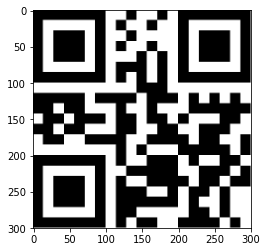

http://byu.edu


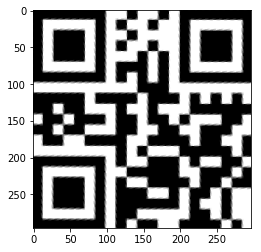

http://byu.edu


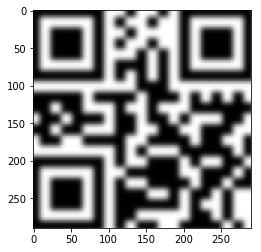

http://byu.edu


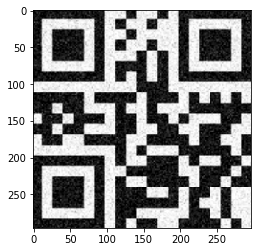

http://DataGenetics.com


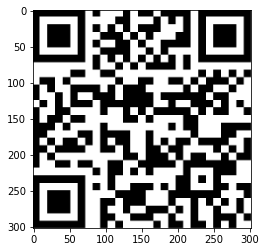

In [6]:
image = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
corners = prep_qr(image)
output = build_qr(image, corners)
d = discretization(output)
decode_qr(d)
plt.imshow(output,cmap="gray");plt.show()

image = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
corners = prep_qr(image)
output = build_qr(image, corners)
d = discretization(output)
decode_qr(d)
plt.imshow(output,cmap="gray");plt.show()

image = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
corners = prep_qr(image)
output = build_qr(image, corners)
d = discretization(output)
decode_qr(d)
plt.imshow(output,cmap="gray");plt.show()

image = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
corners = prep_qr(image)
output = build_qr(image, corners)
d = discretization(output)
decode_qr(d)
plt.imshow(output,cmap="gray");plt.show()

image = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
corners = prep_qr(image)
output = build_qr(image, corners)
d = discretization(output)
decode_qr(d)
plt.imshow(output,cmap="gray");plt.show()


## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



http://byu.edu


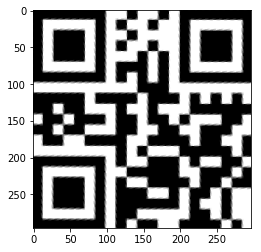

http://byu.edu


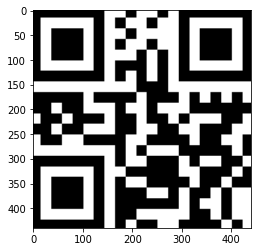

In [7]:
#Challenge #1

image = cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE)
corners = prep_qr(image)
output = build_qr(image, corners)
d = discretization(output)
decode_qr(d)
plt.imshow(output,cmap="gray");plt.show()

# image = cv2.imread("QR_codes/challenge2.png", cv2.IMREAD_GRAYSCALE)
# corners = prep_qr2(image)
# output = build_qr2(image, corners)
# d = discretization(output)
# decode_qr(d)
# plt.imshow(output,cmap="gray");plt.show()

image = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
corners = prep_qr(image)
output = build_qr(image, corners)
d = discretization(output)
decode_qr(d)
plt.imshow(output,cmap="gray");plt.show()

# image = cv2.imread("QR_codes/challenge4.png", cv2.IMREAD_GRAYSCALE)
# corners = prep_qr2(image)
# output = build_qr2(image, corners)
# # d = discretization(output)
# # decode_qr(d)
# plt.imshow(output,cmap="gray");plt.show()


# image = cv2.imread("QR_codes/challenge5.png", cv2.IMREAD_GRAYSCALE)
# corners = prep_qr2(image)
# output = build_qr2(image, corners)
# # d = discretization(output)
# # decode_qr(d)
# plt.imshow(output,cmap="gray");plt.show()



## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here

It was hard to have written my algorithms and then have to change them to fit the challenges. The hardest test was the rotated image by far. The reason it was so hard was figuring out how to crop the image based on location of the four corners seemed impossible. I spent a long time working on that. Eventually, I chose to use the location of the first black pixel in the case it was greater than the location of the corners. The challenges were hard too. 

Challenge 1: I simply created an array for the 4 corners and then calculate which region the corners were coming from and transformed the corners so they would warp correctly. Basically, I had to control where in the array of corners, each corner was allowed to be. The array had to be [topleft,topright, bottomleft, bottomright] and based on where the missing corner was I knew it would need to be rotated the specific way. 
Challenge 3: I simply ran the same algorithms but this time when I went to crop, I cropped based on where the corners where and not based on the first black pixel. Although, that seemed easy, it took me forever to figure out how to find the distince between the corners and the edge of the image, but once I did it wasn't bad.

I would improve the lab giving us teh decoder for the horizontal QR code reader so I could have done challange 5, that would have been good. Also, I wasn't sure if there was a right way to do this or if it was just do it however it works. Either way my results were good and my runtime was fast.
